## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score,\
                            f1_score, roc_curve, precision_recall_curve, accuracy_score

import tensorflow as tf


## Importa dados

In [2]:
# registra o diretório atual e muda para a pasta "dataset"
current_dir_orig = os.getcwd()
os.chdir(f"{current_dir_orig}/dataset")

In [3]:
depfed_dataset_df = pd.read_csv(r'./depfed_dataset.csv')

# change to original directory
os.chdir(current_dir_orig)

In [4]:
depfed_dataset_df.head()

,SQ_CANDIDATO,NM_CANDIDATO,NR_IDADE_DATA_POSSE,REELEICAO,ST_ELEITORAL,COR_RACA_AMARELA,COR_RACA_BRANCA,COR_RACA_INDIGENA,COR_RACA_NAO_INFORMADO,COR_RACA_PARDA,...,RAZAO_CAND_VAGA_UE,RAZAO_CANDPART_VAGAS_UE,PART_PRES_POS,INSTA_FLW,TK_FLW,TK_LIKE,FB_FLW,TWT_FLW,QT_VAGAS_UE,QUOCIENTE_ELEITORAL_UE
0,70001650385,CELY LANGAMER MUNIZ,51,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,25.750000,1.125000,0.00,716,0,0,716,0,8.0,200940.0
1,170001618619,MARCOS BEZERRA CAMPELO,55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,17.320000,0.840000,0.00,671,0,0,671,0,25.0,198795.0
2,220001605554,MARY TERESINHA BRAGANHOL,58,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,19.250000,1.125000,0.02,2635,0,0,2635,0,8.0,108643.0
3,190001609675,FERNANDO DA SILVA FERNANDES,68,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,22.891304,1.021739,0.00,1575,0,0,1575,0,46.0,186435.0
4,130001612965,RAFAEL CANDIDO,32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,19.962264,0.679245,0.00,198,0,0,198,0,53.0,210964.0


### Separa dataset em treinamento e teste

In [5]:
# separa o dataset inicial em treinamento e teste, estratificado pelo resultado eleitoral
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(depfed_dataset_df, depfed_dataset_df["ST_ELEITORAL"]):
    
    strat_train_set = depfed_dataset_df.loc[train_index]
    strat_test_set = depfed_dataset_df.loc[test_index]

# strat_test_set["ST_ELEITORAL"].value_counts()/len(strat_test_set)
depfed_train_df =  strat_train_set.copy().reset_index(drop=True)
depfed_test_df =  strat_test_set.copy().reset_index(drop=True)

### Buscando correlações

In [6]:
# Matriz de correlações
corr_matrix = depfed_train_df.corr()

corr_matrix["ST_ELEITORAL"].sort_values(ascending=False)

ST_ELEITORAL               1.000000
REELEICAO                  0.564909
FUNDO ESPECIAL             0.519590
OUTROS RECURSOS            0.424164
INSTA_FLW                  0.252655
TWT_FLW                    0.240951
FB_FLW                     0.227770
PART_PRES_POS              0.202970
FUNDO PARTIDARIO           0.167828
TK_LIKE                    0.136524
COR_RACA_BRANCA            0.108574
GENERO                     0.092426
TK_FLW                     0.083912
RAZAO_CANDPART_VAGAS_UE    0.034827
NR_IDADE_DATA_POSSE        0.014954
COR_RACA_INDIGENA          0.014443
COR_RACA_AMARELA           0.011531
QUOCIENTE_ELEITORAL_UE     0.001116
QT_VAGAS_UE               -0.001454
SQ_CANDIDATO              -0.002101
COR_RACA_NAO_INFORMADO    -0.011036
RAZAO_CAND_VAGA_UE        -0.019594
COR_RACA_PRETA            -0.063821
COR_RACA_PARDA            -0.069562
Name: ST_ELEITORAL, dtype: float64

In [7]:
# testando combinações de atributos
depfed_train_df["RECEITA_TOTAL"] = depfed_train_df["FUNDO ESPECIAL"] + depfed_train_df["OUTROS RECURSOS"] + \
                                    depfed_train_df["FUNDO PARTIDARIO"]

depfed_train_df["FLW_TOTAL"] = depfed_train_df["INSTA_FLW"] + depfed_train_df["TWT_FLW"] + \
                                depfed_train_df["FB_FLW"] + depfed_train_df["TK_FLW"]

corr_matrix = depfed_train_df.corr()

corr_matrix["ST_ELEITORAL"].sort_values(ascending=False)

ST_ELEITORAL               1.000000
RECEITA_TOTAL              0.576699
REELEICAO                  0.564909
FUNDO ESPECIAL             0.519590
OUTROS RECURSOS            0.424164
FLW_TOTAL                  0.257308
INSTA_FLW                  0.252655
TWT_FLW                    0.240951
FB_FLW                     0.227770
PART_PRES_POS              0.202970
FUNDO PARTIDARIO           0.167828
TK_LIKE                    0.136524
COR_RACA_BRANCA            0.108574
GENERO                     0.092426
TK_FLW                     0.083912
RAZAO_CANDPART_VAGAS_UE    0.034827
NR_IDADE_DATA_POSSE        0.014954
COR_RACA_INDIGENA          0.014443
COR_RACA_AMARELA           0.011531
QUOCIENTE_ELEITORAL_UE     0.001116
QT_VAGAS_UE               -0.001454
SQ_CANDIDATO              -0.002101
COR_RACA_NAO_INFORMADO    -0.011036
RAZAO_CAND_VAGA_UE        -0.019594
COR_RACA_PRETA            -0.063821
COR_RACA_PARDA            -0.069562
Name: ST_ELEITORAL, dtype: float64

<AxesSubplot:xlabel='RECEITA_TOTAL', ylabel='ST_ELEITORAL'>

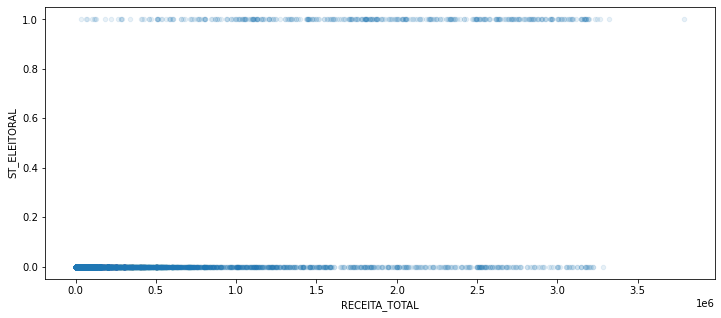

In [8]:
depfed_train_df.plot(kind="scatter", x="RECEITA_TOTAL", y="ST_ELEITORAL", alpha=0.1, figsize=(12,5))

#### Desempenho

Como estamos manipulando **dados assimétricos**, uma vez que a proporção de candidatos eleitos é bem menor do que não eleitos, é normal a acurácia ser bem alta. Para avaliarmos melhor as previsões, usaremos métodos mais robustos.

In [9]:
# proporção de eleitos (1) e não eleitos (0) no conjunto de treinamento
depfed_train_df["ST_ELEITORAL"].value_counts()/len(depfed_train_df)

0.0    0.948596
1.0    0.051404
Name: ST_ELEITORAL, dtype: float64

In [10]:
# guarda os targets em st_eleitoral
y_train = depfed_train_df["ST_ELEITORAL"].values

depfed_dataset = depfed_train_df.drop(['SQ_CANDIDATO','NM_CANDIDATO','ST_ELEITORAL'], axis=1, inplace=False)
depfed_dataset.head()

,NR_IDADE_DATA_POSSE,REELEICAO,COR_RACA_AMARELA,COR_RACA_BRANCA,COR_RACA_INDIGENA,COR_RACA_NAO_INFORMADO,COR_RACA_PARDA,COR_RACA_PRETA,GENERO,FUNDO ESPECIAL,...,PART_PRES_POS,INSTA_FLW,TK_FLW,TK_LIKE,FB_FLW,TWT_FLW,QT_VAGAS_UE,QUOCIENTE_ELEITORAL_UE,RECEITA_TOTAL,FLW_TOTAL
0,65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10256.41,...,0.00,1176,0,0,1176,0,70.0,332736.0,41006.41,2352
1,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40000.00,...,0.00,152,0,0,152,0,46.0,186435.0,40000.00,304
2,43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30000.00,...,0.02,241,0,0,241,0,53.0,210964.0,36060.60,482
3,42,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10000.00,...,0.00,67,0,0,67,0,39.0,204062.0,10000.00,134
4,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.40,3189,0,0,3189,0,8.0,169608.0,150325.53,6378


### Scaling

In [11]:
# pipeline de transformação. As colunas do dataset saem trocadas de acodo com o ColumnTransformer

num_columns = ["NR_IDADE_DATA_POSSE",
               "FUNDO ESPECIAL",
               "OUTROS RECURSOS",
               "FUNDO PARTIDARIO",
               "RAZAO_CAND_VAGA_UE",
               "RAZAO_CANDPART_VAGAS_UE",
               "PART_PRES_POS",
               "INSTA_FLW",
               "TK_FLW",
               "TK_LIKE",
               "FB_FLW",
               "TWT_FLW",
               "QT_VAGAS_UE",
               "QUOCIENTE_ELEITORAL_UE",
               "RECEITA_TOTAL",
               "FLW_TOTAL"
              ]

full_pipeline = ColumnTransformer([("num", StandardScaler(), num_columns)], remainder='passthrough')

X_train_prep = full_pipeline.fit_transform(depfed_dataset)

# full_pipeline.get_feature_names_out(depfed_dataset.columns)

### 1° Classificador - SGD Classifier

In [12]:
# treina SGDClassifier()
sgd_clf = SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.01, l1_ratio=0.6, random_state=42)
sgd_clf.fit(X_train_prep, y_train)


SGDClassifier(alpha=0.01, l1_ratio=0.6, penalty='elasticnet', random_state=42)

In [13]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.grid()
    plt.ylim([0, 1.0])
    plt.xlim([0, 1.0])
    plt.ylabel('Taxa de Verdadeiro Positivo (Recall)')
    plt.xlabel('Taxa de Falso Positivo')

# retorna o score de cada instância de treinamento
y_scores_sgd = cross_val_predict(sgd_clf, X_train_prep, y_train, cv=5, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train, y_scores_sgd)

# curva de precisão vs revocação
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_train, y_scores_sgd)


### 2° Classificador - Random Forest

In [14]:
# treina RandomForestClassifier()
forest_clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, bootstrap=True, random_state=42)
forest_clf.fit(X_train_prep, y_train)


RandomForestClassifier(min_samples_leaf=3, n_estimators=300, random_state=42)

In [15]:
# retorna a probabilidade de cada instância de treinamento
y_probas_forest = cross_val_predict(forest_clf, X_train_prep, y_train, cv=5, method="predict_proba")

# seleciona os scores positivos
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

# curva de precisão vs revocação
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_scores_forest)


### 3° Classificador - Logistic Regression

In [16]:
# treina LogisticRegressionCV()
logreg_clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42, max_iter=10000)
logreg_clf.fit(X_train_prep, y_train)


LogisticRegression(C=0.1, max_iter=10000, penalty='l1', random_state=42,
                   solver='liblinear')

In [17]:
# retorna a probabilidade de cada instância de treinamento
y_probas_logreg = cross_val_predict(logreg_clf, X_train_prep, y_train, cv=5, method="predict_proba")

# seleciona os scores positivos
y_scores_logreg = y_probas_logreg[:, 1]

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_train, y_scores_logreg)

# curva de precisão vs revocação
precisions_logreg, recalls_logreg, thresholds_logreg = precision_recall_curve(y_train, y_scores_logreg)


### 4° Classificador - SVM

In [18]:
# treina SVC()
svc_clf = SVC(C=0.001, kernel='linear', degree=3, probability=True, gamma='scale', tol=0.0001, random_state=42)
svc_clf.fit(X_train_prep, y_train)


SVC(C=0.001, kernel='linear', probability=True, random_state=42, tol=0.0001)

In [19]:
# retorna o score de cada instância de treinamento
y_scores_svc = cross_val_predict(svc_clf, X_train_prep, y_train, cv=5, method="decision_function")

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train, y_scores_svc)

# curva de precisão vs revocação
precisions_svc, recalls_svc, thresholds_svc = precision_recall_curve(y_train, y_scores_svc)


### 5° Classificador - XGBoost

In [20]:
# classificador xgboost já tunado
xgb_clf = XGBClassifier(learning_rate=0.095,
                        n_estimators=130,
                        max_depth=3,
                        min_child_weight=0.75,
                        subsample=0.5,
                        colsample_bytree=0.5,
                        colsample_bynode=0.75,
                        random_state=42,
                        reg_lambda=1.0,
                        reg_alpha=1.0,
                        scale_pos_weight=1.5,
                        num_parallel_tree=1,
                        booster='gbtree'
                        )

xgb_clf.fit(X_train_prep, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.75, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.095, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=0.75, missing=nan,
              monotone_constraints='()', n_estimators=130, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

### Tunagem do XGBoost

Primeiro otimizaram-se os parâmetros ``learning_rate``, ``n_estimators`` e ``max_depth``, obtendo-se os valores de ``auc`` abaixo, que representa a área sobre a curva ROC.

| n     | learning_rate | n_estimators | max_depth | auc |
| ----- | -----------   |-----------   | --------- | --- |
| 77    | 0.177828      | 100          | 4         | 98.116827 |
| 56    | 0.031623      | 250          | 3         | 98.113773 |
| 75    | 0.177828	    | 100          | 2         | 98.109098 |
|86     | 0.100         | 150          | 4         | 98.145042 |
|82     | 0.100         | 100          | 4         | 98.140849|
|69     | 0.075         | 200          | 3         | 98.137470|
|65     | 0.075         | 150          | 3         | 98.136500|
|85     | 0.100         | 150          | 3         | 98.132471|

Definidas os valores acima, otimizou-se os parâmetros ``min_child_weight``, ``subsample``, ``max_depth``, ``colsample_bytree`` e ``colsample_bynode``. Observa-se que os valores da área sobre a curva aumentou, sugerindo que os valores foram mais assertivos.

| min_child_weight | subsample | max_depth  | colsample_bytree | colsample_bynode | auc       |
| ---------------- |---------- | ---------- | ---------------- |----------------- | --------- |
| 0.5              |  0.50     | 2          | 0.5              | 0.75             | 98.214357 |
| 0.5              |  0.75     | 2          | 0.5              | 1.0              | 98.202757 |
| 0.5              |  0.75	   | 2          | 1.0              | 0.5              | 98.201465 |
| 1.0              |  0.75     | 2          | 0.5              | 1.0              | 98.198083 |
| 0.5              |  0.75     | 3          | 0.5              | 1.0              | 98.197591 |

Novamente testamos para os parâmetros ``reg_lambda``, ``reg_alpha`` e ``scale_pos_weight``. Observa-se que os valores da área sobre a curva aumentou, sugerindo que os valores foram mais assertivos.

| min_child_weight | subsample | max_depth  | colsample_bytree | reg_lambda      | reg_alpha | scale_pos_weight | auc  |
| ---------------- |---------- | ---------- | ---------------- |-----------------| --------- | ---------------- | ---- |
| 0.75             | 0.50      | 3          |  0.5             | 1.0             | 1.0       | 1.0              | 98.221603 |
| 0.75             | 0.75      | 3          |  0.5             | 0.75            | 0.75      | 0.75             | 98.212575 |
| 0.50             | 0.50 	   | 3          |  0.5             | 0.50            | 0.50      | 0.50             | 98.212100 |
| 0.35             | 0.50      | 2          |  0.5             | 0.50            | 0.50      | 0.50             | 98.211618 |
| 0.75             | 0.50      | 2          |  0.5             | 0.75            | 0.75      | 0.75             | 98.210808 |


In [21]:
y_probas_xgb = cross_val_predict(xgb_clf, X_train_prep, y_train, cv=5, method="predict_proba")

# seleciona os scores positivos
y_scores_xgb = y_probas_xgb[:, 1]

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_scores_xgb)

# curva de precisão vs revocação
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_train, y_scores_xgb)


### Gráficos

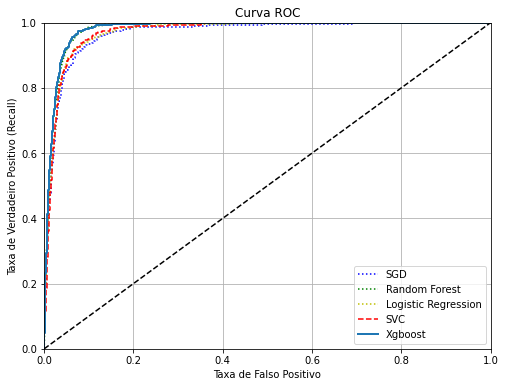

In [22]:
# Plot
plt.figure(figsize=(8,6))
plt.title("Curva ROC")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, "g:", label="Random Forest")
plt.plot(fpr_logreg, tpr_logreg, "y:", label="Logistic Regression")
plt.plot(fpr_svc, tpr_svc, "r--", label="SVC")
plot_roc_curve(fpr_xgb, tpr_xgb, label="Xgboost")
plt.legend(loc="lower right")
plt.show()

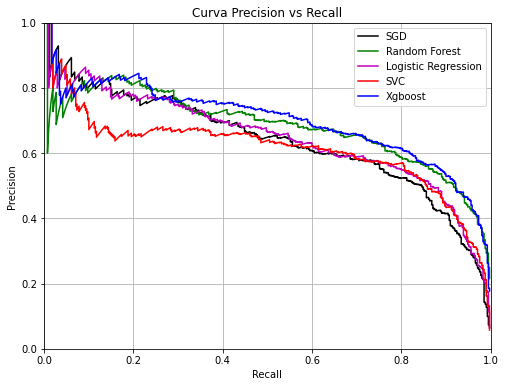

In [23]:
# Plot
plt.figure(figsize=(8,6))
plt.title("Curva Precision vs Recall")
plt.grid()

plt.plot(recalls_sgd[100:], precisions_sgd[100:], "k-", label="SGD")
plt.plot(recalls_forest[200:], precisions_forest[200:], "g-", label="Random Forest")
plt.plot(recalls_logreg[200:], precisions_logreg[200:], "m-", label="Logistic Regression")
plt.plot(recalls_svc[200:], precisions_svc[200:], "r-", label="SVC")
plt.plot(recalls_xgb[200:], precisions_xgb[200:], "b-", label="Xgboost")

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.show()

### Scores dos modelos

In [24]:
# listas para receber os scores
roc_auc = []
accuracy = []
precision = []
recall = []
f1_scr = []
modelo = []

# tupla com os modelos
clf_models = (sgd_clf, forest_clf, logreg_clf, svc_clf, xgb_clf)

for clf in clf_models:
    
    y_pred = cross_val_predict(clf, X_train_prep, y_train, cv=5)
    
    if clf in (sgd_clf, svc_clf):
        roc_auc.append(roc_auc_score(y_train, cross_val_predict(clf, X_train_prep, y_train, cv=5, method="decision_function")))
    else:
        roc_auc.append(roc_auc_score(y_train, cross_val_predict(clf, X_train_prep, y_train, cv=5, method="predict_proba")[:,1]))
        
    accuracy.append(accuracy_score(y_train, y_pred))
    precision.append(precision_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    f1_scr.append(f1_score(y_train, y_pred))
    modelo.append(clf.__class__.__name__)
    print(confusion_matrix(y_train, y_pred))


[[7473   93]
 [ 225  185]]
[[7455  111]
 [ 173  237]]
[[7463  103]
 [ 205  205]]
[[7553   13]
 [ 372   38]]
[[7417  149]
 [ 124  286]]


In [25]:
# dataframe com os scores consolidados
df = pd.DataFrame({"roc_auc": roc_auc,
                   "accuracy": accuracy,
                   "precision": precision,
                   "recall": recall,
                   "f1_score": f1_scr,
                   "modelo": modelo}
                 ).sort_values("f1_score", ascending=False, ignore_index=True)

df

,roc_auc,accuracy,precision,recall,f1_score,modelo
0,0.981401,0.965772,0.657471,0.697561,0.676923,XGBClassifier
1,0.979688,0.964393,0.681034,0.578049,0.625330,RandomForestClassifier
2,0.971770,0.961384,0.665584,0.500000,0.571031,LogisticRegression
3,0.967519,0.960130,0.665468,0.451220,0.537791,SGDClassifier
4,0.971137,0.951730,0.745098,0.092683,0.164859,SVC


#### Escolha do modelo
Utilizando a métrica de ``f1_score`` como parâmetro de performance, o modelo de **XGBClassifier** é o mais performático entre os 5 modelos utilizados. Todos os modelos foram devidamente otimizados, tunando seus hiper parâmetros para alcançarem a melhor performance, mas mantendo sua capacidade de generalização para novos dados.

### Validação com dataset de teste

In [26]:
# faz as modificacoes que foram feitas no dataset de treino
depfed_test_df["RECEITA_TOTAL"] = depfed_test_df["FUNDO ESPECIAL"] + depfed_test_df["OUTROS RECURSOS"] + \
                                    depfed_test_df["FUNDO PARTIDARIO"]

depfed_test_df["FLW_TOTAL"] = depfed_test_df["INSTA_FLW"] + depfed_test_df["TWT_FLW"] + \
                                depfed_test_df["FB_FLW"] + depfed_test_df["TK_FLW"]

# targets de teste
y_test = depfed_test_df["ST_ELEITORAL"].values

depfed_test_df = depfed_test_df.drop(['SQ_CANDIDATO','NM_CANDIDATO','ST_ELEITORAL'], axis=1, inplace=False)
depfed_test_df.head()

,NR_IDADE_DATA_POSSE,REELEICAO,COR_RACA_AMARELA,COR_RACA_BRANCA,COR_RACA_INDIGENA,COR_RACA_NAO_INFORMADO,COR_RACA_PARDA,COR_RACA_PRETA,GENERO,FUNDO ESPECIAL,...,PART_PRES_POS,INSTA_FLW,TK_FLW,TK_LIKE,FB_FLW,TWT_FLW,QT_VAGAS_UE,QUOCIENTE_ELEITORAL_UE,RECEITA_TOTAL,FLW_TOTAL
0,29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5022.0,...,0.0,987,0,14600,987,0,25.0,198795.0,6114.00,1974
1,54,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,952,0,0,952,0,31.0,198381.0,2040.00,1904
2,31,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,27,0,0,27,0,8.0,108643.0,0.00,54
3,34,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,3533,0,0,3533,0,9.0,183418.0,2614.34,7066
4,43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4000.0,...,0.0,425,0,0,425,0,46.0,186435.0,4000.00,850


In [27]:
# aplica a transfomação feita no treino no dataset de teste
X_test_prep = full_pipeline.transform(depfed_test_df)

In [28]:
# previsão nos dados de teste
y_pred = xgb_clf.predict(X_test_prep)

roc_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test_prep)[:, 1])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_scr = f1_score(y_test, y_pred)

print("Scores no dataset de teste")
print("roc_auc: ", roc_auc)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1_score: ", f1_scr)

Scores no dataset de teste
roc_auc:  0.9847668824734436
accuracy:  0.9633901705115346
precision:  0.631578947368421
recall:  0.6990291262135923
f1_score:  0.6635944700460831


Comparando-se os scores de teste e treinamento, observa-se que eles estão **bem próximos**. Isto é excelente, mostrando que o modelo consegue generalizar com consistência (modelo devidamente ajustado aos dados).

Agora, para finalizar, podemos treinar o modelo em todo o dataset.

In [29]:
# faz as modificacoes que foram feitas no dataset de treino e teste
depfed_dataset_df["RECEITA_TOTAL"] = depfed_dataset_df["FUNDO ESPECIAL"] + depfed_dataset_df["OUTROS RECURSOS"] + \
                                    depfed_dataset_df["FUNDO PARTIDARIO"]

depfed_dataset_df["FLW_TOTAL"] = depfed_dataset_df["INSTA_FLW"] + depfed_dataset_df["TWT_FLW"] + \
                                depfed_dataset_df["FB_FLW"] + depfed_dataset_df["TK_FLW"]

# targets de teste
y_full = depfed_dataset_df["ST_ELEITORAL"].values

depfed_dataset_full_df = depfed_dataset_df.drop(['SQ_CANDIDATO','NM_CANDIDATO','ST_ELEITORAL'], axis=1, inplace=False)

# aplica a transfomação feita no treino no dataset de teste
X_full = full_pipeline.transform(depfed_dataset_full_df)

In [30]:
X_full.shape

(9970, 24)

In [31]:
xgb_clf.fit(X_full, y_full)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.75, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.095, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=0.75, missing=nan,
              monotone_constraints='()', n_estimators=130, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [32]:
# previsão nos dados de teste
y_full_pred = xgb_clf.predict(X_full)

roc_auc = roc_auc_score(y_full, xgb_clf.predict_proba(X_full)[:, 1])
accuracy = accuracy_score(y_full, y_full_pred)
precision = precision_score(y_full, y_full_pred)
recall = recall_score(y_full, y_full_pred)
f1_scr = f1_score(y_full, y_full_pred)

print("Scores no dataset de teste")
print("roc_auc: ", roc_auc)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1_score: ", f1_scr)

Scores no dataset de teste
roc_auc:  0.9924865622399613
accuracy:  0.9779338014042126
precision:  0.7565674255691769
recall:  0.8421052631578947
f1_score:  0.7970479704797048


### Download dataset

In [33]:
depfed_pred_df = depfed_dataset_df.copy()

depfed_pred_df["Y_PRED"] = xgb_clf.predict_proba(X_full)[:, 1]
depfed_pred_df["ST_ELEITORAL_PRED"] = y_full_pred

depfed_pred_df.to_csv(r'./dataset/depfed_pred_df.csv',
                         encoding = 'utf-8-sig',
                         index = False)

### Dump do modelo

In [42]:
joblib.dump(xgb_clf, os.path.join(r'./gradio_spaces_app/depfed_previsao_eleicao', "model.pkl"))
joblib.dump(full_pipeline, os.path.join(r'./gradio_spaces_app/depfed_previsao_eleicao', "scaler.pkl"))

['./gradio_spaces_app/depfed_previsao_eleicao\\scaler.pkl']